In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
import sys
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import kruskal

from classes import boundaries as bd
from classes import functions as fcy
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False

#--- Options
store = False
plot  = True
# Significance level difference between data groups
alpha=0.001 

In [10]:
#---------------#
#  Import data  #
#---------------#


#--- Site MTF
site_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Site_MTF')
site_mtf.loc[site_mtf['Site name'].isna(),'Site name'] = ''
site_mtf.loc[site_mtf['Y coords'].isna(),'Y coords'] = ''
site_mtf.loc[site_mtf['X coords'].isna(),'X coords'] = ''
site_mtf_cp = site_mtf.copy()

# Select data
site_mtf = site_mtf[site_mtf['MTF basis'] == 'count']

#--- Species
species_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Species_MTF')
species_mtf.loc[species_mtf['Site name'].isna(),'Site name'] = ''
species_mtf.loc[species_mtf['Y coords'].isna(),'Y coords'] = ''
species_mtf.loc[species_mtf['X coords'].isna(),'X coords'] = ''
species_mtf_cp = species_mtf.copy()

# Select data
species_mtf = species_mtf[species_mtf['MTF basis'] == 'count']

		 YES 	 NO
#--- SPECIES
PFT 	 112 	 34
FIRE 		 57 	 89
MANAGED 	 54 	 92
Applies       	 Yes 	 No
#--- SITE
PFT 	 78 	 6
FIRE 		 25 	 60
MANAGED 	 31 	 54


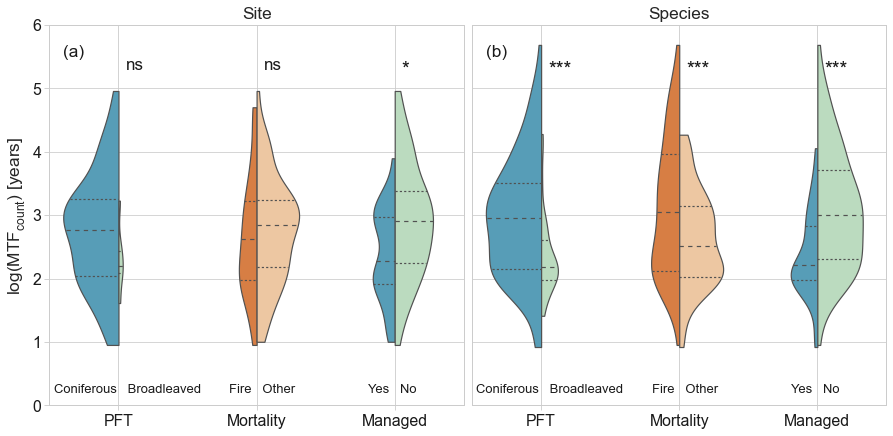

In [11]:
refs_non_valid = ['Ritchie2014EstablishmentForest','Campbell2016CarbonStates']

#--------------------------------#
#   Visualising the categories   # 
#--------------------------------#
#--- SPECIES
cru     = species_mtf
cru     = cru[~cru.Reference.isin(refs_non_valid)].copy()
cru_spe = cru.copy()
cru_bool_ss = cru.loc[cru['MTF basis'] == 'count', ['MTF',
                                                    'Fire', 
                                                    'PFT', 
                                                    'Managed', 
                                                    'Reference'
                                                   ]].copy()
cru_bool_ss.columns = cru_bool_ss.columns.get_level_values(0)

ref_spe = cru_bool_ss.Reference.unique()
cru_bool_ss.head()
cru_bool_ss.melt()

cols = [ 'PFT','Fire', 'Managed']

df_list = []

print('\t\t YES \t NO')
print('#--- SPECIES')
for var in cols:
    cru_melt = pd.melt(cru_bool_ss, id_vars=[var], value_vars=['MTF'])
    cru_melt.loc[cru_melt[var] == 0, var] = 'No'
    cru_melt.loc[cru_melt[var] == 1, var] = 'Yes'
    
    cru_melt.columns  = ['Bool', 'Variable', 'MTF' ]
    cru_melt.Variable = var
    cru_melt.Variable = pd.Categorical(cru_melt.Variable)
    if var == 'Fire':
        print(var.upper(), '\t\t', len(cru_melt[cru_melt.Bool == 'Yes']),'\t', len(cru_melt[cru_melt.Bool == 'No']))
    else:
        print(var.upper(), '\t', len(cru_melt[cru_melt.Bool == 'Yes']),'\t', len(cru_melt[cru_melt.Bool == 'No']))
    df_list.append(cru_melt)

cru_bool_all = pd.concat(df_list, axis=0).reset_index(drop=True)
cru_bool_all.Variable = pd.Categorical(cru_bool_all.Variable)
cru_bool_all.Bool = pd.Categorical(cru_bool_all.Bool)

cru_bool_all = cru_bool_all.dropna()
cru_bool_all.columns  = ['Bool', 'Variable', 'MTF' ]
cru_bool_all.MTF = np.log(cru_bool_all.MTF)
cru_bool_all_species = cru_bool_all.copy()





#--- SITE
print('Applies       \t Yes \t No')
print('#--- SITE')
cru      = site_mtf
cru      = cru[~cru.Reference.isin(refs_non_valid)].copy()
cru_site = cru.copy()
# Visualising the categorical data of the dataset
cru_bool_ss = cru.loc[cru['MTF basis'] == 'count', ['MTF',
                                                    'PFT',
                                                    'Fire', 
                                                    'Managed', 
                                                    'Reference'
                                                   ]].copy()
cru_bool_ss.columns = cru_bool_ss.columns.get_level_values(0)

cru_bool_ss.head()
cru_bool_ss.melt()

cols = ['PFT','Fire', 'Managed',]

df_list = []
for var in cols:
    cru_melt = pd.melt(cru_bool_ss, id_vars=[var], value_vars=['MTF'])
    cru_melt.loc[cru_melt[var] == 1, var] = 'Yes'
    cru_melt.loc[cru_melt[var] == 0, var] = 'No'
    cru_melt.columns  = ['Bool', 'Variable', 'MTF' ]
    cru_melt.Variable = var
    cru_melt.Variable = pd.Categorical(cru_melt.Variable)
    if var == 'Fire':
        print(var.upper(), '\t\t', len(cru_melt[cru_melt.Bool == 'Yes']),'\t', len(cru_melt[cru_melt.Bool == 'No']))
    else:
        print(var.upper(), '\t', len(cru_melt[cru_melt.Bool == 'Yes']),'\t', len(cru_melt[cru_melt.Bool == 'No']))
    df_list.append(cru_melt)

cru_bool_all = pd.concat(df_list, axis=0).reset_index(drop=True)
cru_bool_all.Variable = pd.Categorical(cru_bool_all.Variable)
cru_bool_all.Bool = pd.Categorical(cru_bool_all.Bool)

cru_bool_all = cru_bool_all.dropna()
cru_bool_all.columns  = ['Bool', 'Variable', 'MTF' ]
cru_bool_all.MTF = np.log(cru_bool_all.MTF)
cru_bool_all_site = cru_bool_all.copy()






from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection


cm = 'GnBu_r'
colors = sns.color_palette('Set2')
colors = np.array([(0.34111111111111125, 0.6147058823529412, 0.7190196078431371), 
                   (0.7327450980392157, 0.8581045751633988, 0.7501307189542484), 
                   (0.8414140715109575, 0.49572549019607837, 0.26540638216070733), 
                   (0.9292387543252596, 0.7786243752402922, 0.6356209150326797),
                   (0.34111111111111125, 0.6147058823529412, 0.7190196078431371), 
                   (0.7327450980392157, 0.8581045751633988, 0.7501307189542484), ],dtype='object')
#--- PLOT
import warnings
import matplotlib as mpl
sns.set_context("paper", font_scale=1.8)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'

fig, ax = plt.subplots(1,2, figsize=(15,7), sharey=True)
g = sns.violinplot(x="Variable", y="MTF", hue="Bool", ax=ax[0],
                   hue_order=['Yes','No'],
                   order=cols,
                   data=cru_bool_all_site, 
                   palette=cm, 
                   split=True, 
                   scale="count", 
                   inner="quartile", # Show quartiles of the distribution
                   scale_hue=False,  # Scale the density relative to the counts across all bins:
                   bw=.4,            # Use narrow bandwith to reduce smoothing
                   cut=0
                  )
ax[0].legend([],[], frameon=False)

g = sns.violinplot(x="Variable", y="MTF", hue="Bool", ax=ax[1],
                   hue_order=['Yes','No'],
                   order=cols,
                   data=cru_bool_all_species, 
                   palette=cm, 
                   split=True, 
                   scale="count", 
                   inner="quartile", 
                   scale_hue=False,  
                   bw=.4,
                   cut=0
                  )
# Set colors for the violins
for x in range(2):
    for ind, violin in enumerate(ax[x].findobj(PolyCollection)):
        rgb = colors[ind]
        violin.set_facecolor(rgb)
        
        # plot the vertical gridlines
        ax[x].axvline(x=0, color='lightgrey',zorder=-2, linewidth=0.5)
        ax[x].axvline(x=1, color='lightgrey',zorder=-2, linewidth=0.5)
        ax[x].axvline(x=2, color='lightgrey',zorder=-2, linewidth=0.5)
    

#--- Plot annotations
ax[0].annotate(xy=(-0.4,5.5),text='(a)',color='k') # Plot number
ax[1].annotate(xy=(-0.4,5.5),text='(b)',color='k')

# Statistical signficance
ax[0].annotate(xy=(0.05,5.3),text='ns',color='k',fontsize=17)
ax[0].annotate(xy=(1.05,5.3),text='ns',color='k',fontsize=17)
ax[0].annotate(xy=(2.05,5.2),text='*',color='k',fontsize=20)
ax[1].annotate(xy=(0.05,5.2),text='***',color='k',fontsize=20)
ax[1].annotate(xy=(1.05,5.2),text='***',color='k',fontsize=20)
ax[1].annotate(xy=(2.05,5.2),text='***',color='k',fontsize=20)

# Violin categories
ax[0].annotate(xy=(-0.47,0.2),text='Coniferous   Broadleaved',color='k', fontsize=13)
ax[0].annotate(xy=(0.8,0.2),text='Fire   Other',color='k', fontsize=13)
ax[0].annotate(xy=(1.81,0.2),text='Yes   No',color='k', fontsize=13)
ax[1].annotate(xy=(-0.47,0.2),text='Coniferous   Broadleaved',color='k', fontsize=13)
ax[1].annotate(xy=(0.8,0.2),text='Fire   Other',color='k', fontsize=13)
ax[1].annotate(xy=(1.81,0.2),text='Yes   No',color='k', fontsize=13)


#--- Plot formatting
ax[0].set_xlabel(None)
ax[0].set_title('Site')
ax[0].set_ylabel("$log(MTF_{count})$ [years]")
ax[1].set_xlabel(None)
ax[1].set_title('Species')
ax[1].set_ylabel("")
ax[1].legend([], [], frameon=False)
plt.subplots_adjust(wspace=0.02)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].set_yticklabels(np.arange(0,8),color='k')
    ax[0].set_xticklabels(['PFT', 'Mortality', 'Managed'], color='k')
    ax[1].set_xticklabels(['PFT', 'Mortality', 'Managed'], color='k')
    ax[1].yaxis.set_ticks_position('none')
    
plt.ylim(-0,6)
plt.savefig('Figure3_logMTF_site_species_categories_violin.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
subset = False

bd.print_TITLE('Management influence on MTF')
bd.print_header('Site')
if subset:
    cru_site.dropna(subset=['Aridity','Temp_°C','DBH mean','Conifer', 'MTF'], inplace=True)
cru_site.loc[cru_site.Managed.isna(), 'Managed'] = 2
avg_mtf_mananagement_cat_site      = cru_site.groupby(['Managed','MTF basis','Mortality'])['MTF'].mean().to_frame()
avg_mtf_mananagement_cat_site['n'] = cru_site.groupby(['Managed','MTF basis','Mortality'])['MTF'].count()
display(avg_mtf_mananagement_cat_site)

bd.print_header('Species')
if subset:
    cru_spe.dropna(subset=['Aridity','Temp_°C','DBH mean','Conifer','MTF'], inplace=True)
cru_spe.loc[cru_spe.Managed.isna(), 'Managed'] = 2
avg_mtf_mananagement_cat_spe      = cru_spe.groupby(['Managed','MTF basis','Mortality'])['MTF'].mean().to_frame()
avg_mtf_mananagement_cat_spe['n'] = cru_spe.groupby(['Managed','MTF basis','Mortality'])['MTF'].count()
display(avg_mtf_mananagement_cat_spe)



             Management influence on MTF             



#----------#
#   Site   #
#----------#



MTF   n
Managed MTF basis Mortality               
0.0     count     Fire       26.608875  20
                  Insects     9.989938   8
                  Other      34.057007  26
1.0     count     Fire        9.198541   5
                  Insects    10.200523   6
                  Other      16.087335  20


#-------------#
#   Species   #
#-------------#



MTF   n
Managed MTF basis Mortality               
0.0     count     Fire       45.703994  50
                  Insects    12.022249   3
                  Other      23.650242  39
1.0     count     Fire        9.080614   7
                  Insects    13.263647   8
                  Other      14.530626  39

In [13]:
#--- SPECIES
bd.print_TITLE('SPECIES')
cru = species_mtf.copy()
cru     = cru[~cru.Reference.isin(refs_non_valid)].copy()
# Visualising the categorical data of the dataset
cru_bool_ss = cru.loc[cru['MTF basis'] == 'count',['MTF',
                                                   'PFT',
                                                   'Fire', 
                                                   'Managed', 
                                                   'Reference'
                                                   ]].copy()
cru_bool_ss.columns = cru_bool_ss.columns.get_level_values(0)
cru_bool_ss.MTF = cru_bool_ss.MTF.apply(np.log)
cru_bool_ss = cru_bool_ss.dropna(subset=['MTF', 'Fire', 'PFT', 'Managed', 'Reference']).copy()

#--- Make t-test between groups of data

# Fire
bd.print_header('Fire')
a = cru_bool_ss[cru_bool_ss.Fire == 0].MTF.values
b = cru_bool_ss[cru_bool_ss.Fire == 1].MTF.values
stat, p = levene(a, b)
print('Mean a:{0}, b:{1}'.format('%.1f'%np.mean(a),'%.1f'%np.mean(b)))
print('Variance: ', np.var(a)/np.var(b),np.var(a),np.var(b))
if p > alpha:
    print('Fire has homogeneity of variances.')
    display(ttest_ind(a,b))
else:
    display(kruskal(a,b))


# PFT
bd.print_header('PFT')
a = cru_bool_ss[cru_bool_ss.PFT == 0].MTF.values
b = cru_bool_ss[cru_bool_ss.PFT == 1].MTF.values
stat, p = levene(a, b)
print('Mean a:{0}, b:{1}'.format('%.1f'%np.mean(a),'%.1f'%np.mean(b)))
print('Variance: ', np.var(a)/np.var(b),np.var(a,ddof=1),np.var(b, ddof=1), p)
if p > alpha:
    print('PFT has homogeneity of variances.')
    display(ttest_ind(a,b))
else:
    display(kruskal(a,b))


# Managed
bd.print_header('Managed')
a = cru_bool_ss[cru_bool_ss.Managed == 0].MTF.values
b = cru_bool_ss[cru_bool_ss.Managed == 1].MTF.values
stat, p = levene(a, b)
print('Mean a:{0}, b:{1}'.format('%.1f'%np.mean(a),'%.1f'%np.mean(b)))
print('Variance: ', np.var(a)/np.var(b),np.var(a),np.var(b))
if p > alpha:
    print('Managed has homogeneity of variances.')
    display(ttest_ind(a,b))
else:
    display(kruskal(a,b))



             SPECIES             



#----------#
#   Fire   #
#----------#

Mean a:2.6, b:3.1
Variance:  0.49033322236612414 0.5583408240400085 1.138696703734882


KruskalResult(statistic=6.601750215661617, pvalue=0.010187857437144064)


#---------#
#   PFT   #
#---------#

Mean a:2.3, b:3.0
Variance:  0.41830118125898585 0.388121382766293 0.9086749289472041 0.0011724301730651142
PFT has homogeneity of variances.


Ttest_indResult(statistic=-3.5156793750008357, pvalue=0.0005868426780378091)


#-------------#
#   Managed   #
#-------------#

Mean a:3.1, b:2.4
Variance:  1.9519908959563177 0.8859786756773294 0.45388463517565303
Managed has homogeneity of variances.


Ttest_indResult(statistic=4.862510491070508, pvalue=2.9988102723242696e-06)

In [14]:
#--- SITE
bd.print_TITLE('SITE')
cru        = site_mtf.copy()
# Visualising the categorical data of the dataset
cru = cru_site.copy()
cru_bool_ss = cru.loc[cru['MTF basis'] == 'count',['MTF',
                                                   'PFT',
                                                   'Fire', 
                                                   'Managed', 
                                                   'Reference'
                                                   ]].copy()
cru_bool_ss.columns = cru_bool_ss.columns.get_level_values(0)
cru_bool_ss.MTF = cru_bool_ss.MTF.apply(np.log)
cru_bool_ss = cru_bool_ss.dropna(subset=['MTF', 'Fire', 'PFT', 'Managed']).copy()

#--- Make t-test between groups of data


bd.print_header('Fire')
a = cru_bool_ss[cru_bool_ss.Fire == 0].MTF.values
b = cru_bool_ss[cru_bool_ss.Fire == 1].MTF.values
stat, p = levene(a, b)
if p > alpha:
    print('Fire has homogeneity of variances.')
    display(ttest_ind(a,b))
else:
    display(kruskal(a,b))


bd.print_header('PFT')
a = cru_bool_ss[cru_bool_ss.PFT == 0].MTF.values
b = cru_bool_ss[cru_bool_ss.PFT == 1].MTF.values
stat, p = levene(a, b)
if p > alpha:
    print('PFT has homogeneity of variances.')
    display(ttest_ind(a,b))
else:
    display(kruskal(a,b))


bd.print_header('Managed')
a = np.exp(cru_bool_ss[cru_bool_ss.Managed == 0].MTF.values)
b = np.exp(cru_bool_ss[cru_bool_ss.Managed == 1].MTF.values)
stat, p = levene(a, b)
if p > alpha:
    print('Managed has homogeneity of variances.')
    display(ttest_ind(a,b))
else:
    display(kruskal(a,b))



             SITE             



#----------#
#   Fire   #
#----------#

Fire has homogeneity of variances.


Ttest_indResult(statistic=0.47299348742795666, pvalue=0.6374744765743747)


#---------#
#   PFT   #
#---------#

PFT has homogeneity of variances.


Ttest_indResult(statistic=-1.1823100637813044, pvalue=0.24049974979247465)


#-------------#
#   Managed   #
#-------------#

Managed has homogeneity of variances.


Ttest_indResult(statistic=2.6212159678083817, pvalue=0.01044010002752126)